In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [4]:
# Data Cleaning
# Rename columns for consistency
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Check for invalid null values (e.g., '@', '#', 'NA', '-')
print("\nChecking for invalid null values:")
for col in df.columns:
    invalid_values = df[col].isin(['@', '#', 'NA', '-']).sum()
    if invalid_values > 0:
        print(f"Column {col} has {invalid_values} invalid values")
        df[col] = df[col].replace(['@', '#', 'NA', '-'], np.nan)


Checking for invalid null values:


# Data overview

In [3]:
# STEP 1: Data Overview
# Load the dataset
df = pd.read_csv('event_driven_stock_prediction_dataset.csv')

# Data source
print("Data Source: Provided CSV file 'event_driven_stock_prediction_dataset.csv'")
print("\nDataset Size:", df.shape)
print("\nColumn Information:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())
print("\nData Types:")
print(df.dtypes)


Data Source: Provided CSV file 'event_driven_stock_prediction_dataset.csv'

Dataset Size: (5000, 16)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   5000 non-null   object 
 1   company                5000 non-null   object 
 2   event_type             5000 non-null   object 
 3   event_sentiment_score  5000 non-null   float64
 4   event_keywords         5000 non-null   object 
 5   news_headline_length   5000 non-null   int64  
 6   news_article_length    5000 non-null   int64  
 7   stock_price_before     5000 non-null   float64
 8   stock_price_after      5000 non-null   float64
 9   price_change_percent   5000 non-null   float64
 10  is_positive_movement   5000 non-null   int64  
 11  volume_traded          5000 non-null   int64  
 12  executive_change_flag  5000 non-null  

#  Data Processing

In [33]:
# Data Cleaning
# Rename columns for consistency
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Check for invalid null values (e.g., '@', '#', 'NA', '-')
print("\nChecking for invalid null values:")
for col in df.columns:
    invalid_values = df[col].isin(['@', '#', 'NA', '-']).sum()
    if invalid_values > 0:
        print(f"Column {col} has {invalid_values} invalid values")
        df[col] = df[col].replace(['@', '#', 'NA', '-'], np.nan)


Checking for invalid null values:


In [5]:
# Null Value Handling
print("\nNull Value Percentage:")
null_percentages = df.isnull().mean() * 100
print(null_percentages)


Null Value Percentage:
date                     0.0
company                  0.0
event_type               0.0
event_sentiment_score    0.0
event_keywords           0.0
news_headline_length     0.0
news_article_length      0.0
stock_price_before       0.0
stock_price_after        0.0
price_change_percent     0.0
is_positive_movement     0.0
volume_traded            0.0
executive_change_flag    0.0
funding_announcement     0.0
ai_focus_score           0.0
region                   0.0
dtype: float64


In [6]:
# Apply null value handling laws
for col in df.columns:
    null_pct = null_percentages[col]
    if null_pct > 75:
        print(f"Dropping column {col} due to >75% null values")
        df = df.drop(columns=col)
    elif 20 <= null_pct <= 70:
        if df[col].dtype in ['int64', 'float64']:
            print(f"Imputing {col} with mean")
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            print(f"Imputing {col} with mode")
            df[col].fillna(df[col].mode()[0], inplace=True)
    elif null_pct > 0 and null_pct < 15:
        print(f"Dropping rows with null values in {col}")
        df = df.dropna(subset=[col])


In [7]:
# Outlier Treatment
def treat_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    df = treat_outliers(df, col)


Univariate Analysis for event_sentiment_score:
Min: -0.3, Max: 1.0, Mean: 0.49582800000000005


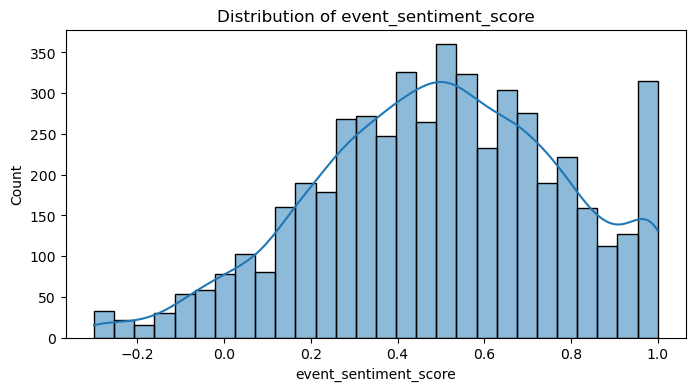


Univariate Analysis for news_headline_length:
Min: 40, Max: 120, Mean: 79.8978


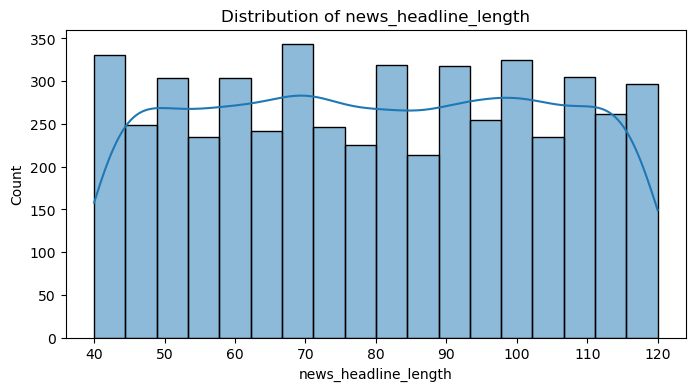


Univariate Analysis for news_article_length:
Min: 501, Max: 2000, Mean: 1256.5382


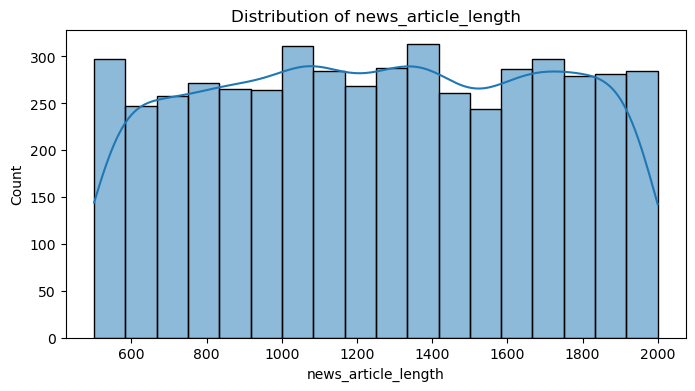


Univariate Analysis for stock_price_before:
Min: 100.02, Max: 599.94, Mean: 347.47785


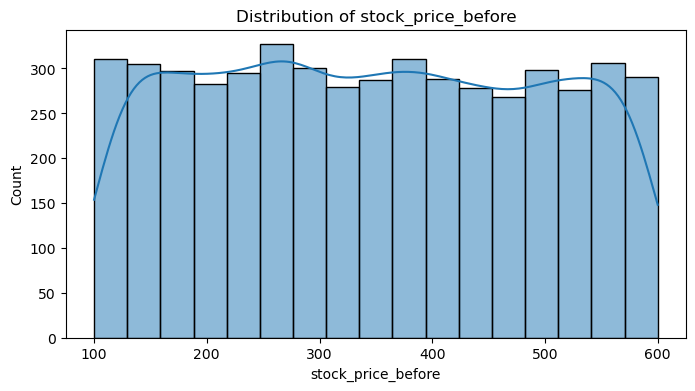


Univariate Analysis for stock_price_after:
Min: 98.69, Max: 622.33, Mean: 349.417586


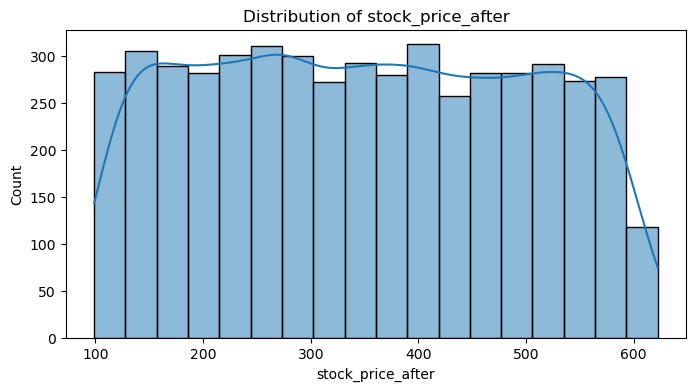


Univariate Analysis for price_change_percent:
Min: -4.9, Max: 5.98, Mean: 0.5569860000000001


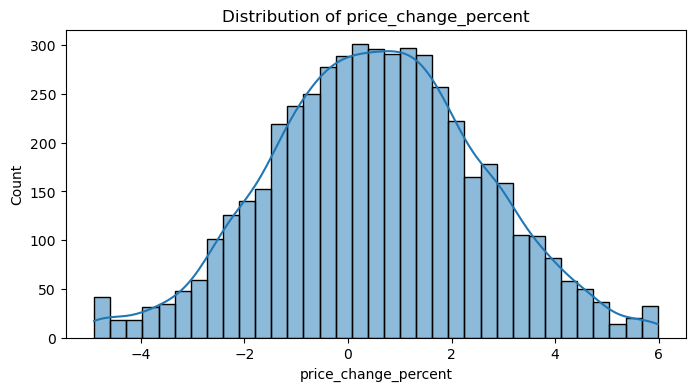


Univariate Analysis for is_positive_movement:
Min: 0, Max: 1, Mean: 0.6046


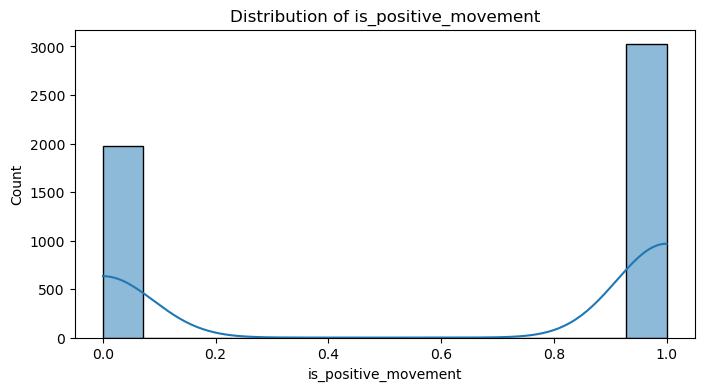


Univariate Analysis for volume_traded:
Min: 1004084, Max: 49990662, Mean: 25746396.9642


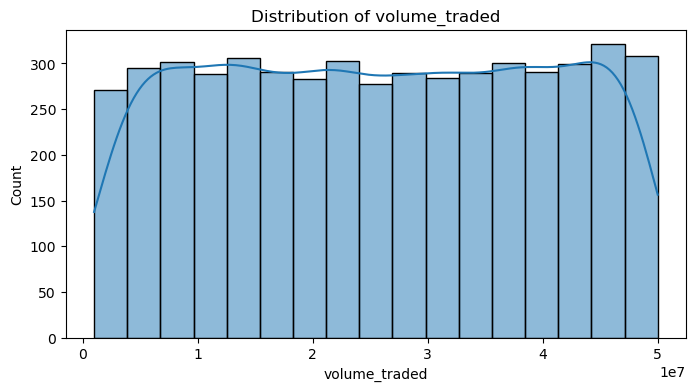


Univariate Analysis for executive_change_flag:
Min: 0, Max: 1, Mean: 0.4922


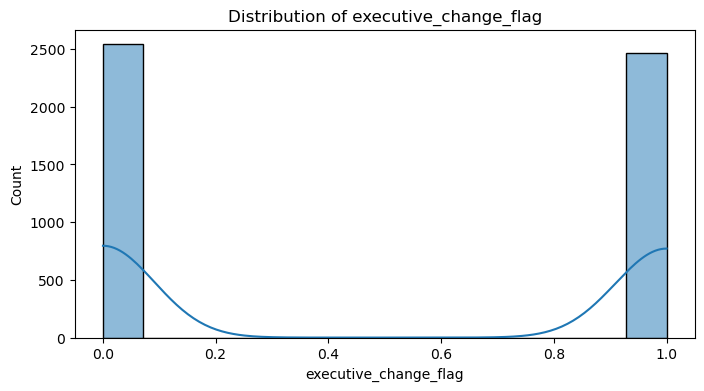


Univariate Analysis for funding_announcement:
Min: 0, Max: 0, Mean: 0.0


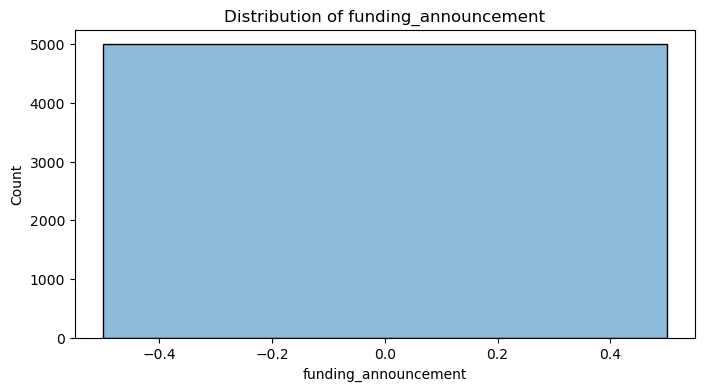


Univariate Analysis for ai_focus_score:
Min: 0.0, Max: 1.0, Mean: 0.45958999999999994


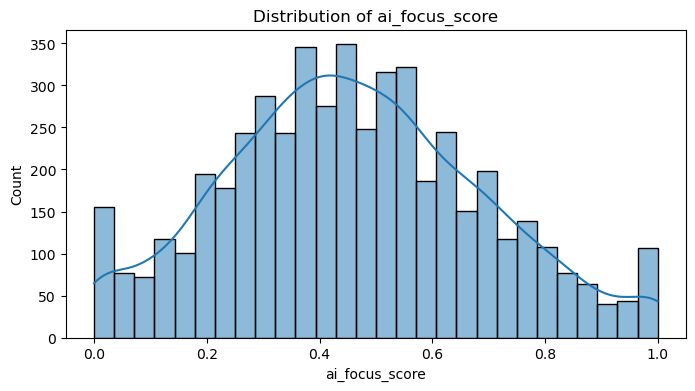

In [8]:
# STEP 3: Exploratory Data Analysis (EDA)
# Univariate Analysis
# Numerical columns
for col in numerical_cols:
    print(f"\nUnivariate Analysis for {col}:")
    print(f"Min: {df[col].min()}, Max: {df[col].max()}, Mean: {df[col].mean()}")
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()



Univariate Analysis for date:
date
2025-09-26    12
2024-05-19    11
2025-01-14    11
2025-02-11    11
2025-06-15    10
              ..
2024-03-12     1
2023-07-21     1
2023-07-03     1
2024-11-29     1
2024-11-23     1
Name: count, Length: 1086, dtype: int64


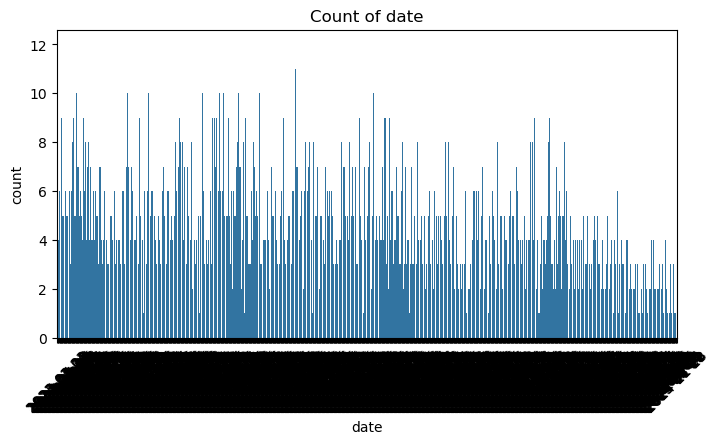


Univariate Analysis for company:
company
Microsoft    865
Amazon       856
Meta         856
Apple        848
Nvidia       797
Google       778
Name: count, dtype: int64


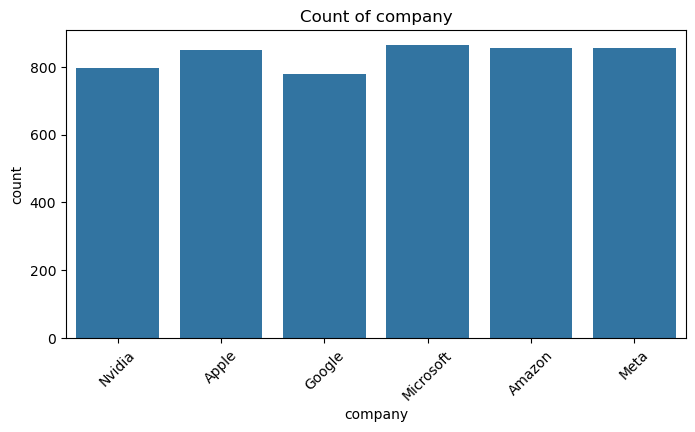


Univariate Analysis for event_type:
event_type
Funding Round        1063
AI product launch    1034
Patent Filing         985
Leadership Change     964
Expansion             954
Name: count, dtype: int64


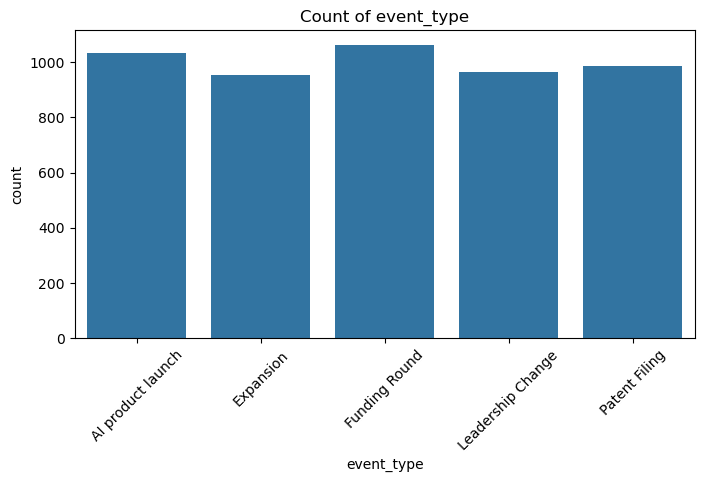


Univariate Analysis for event_keywords:
event_keywords
robotics, expansion, AI          58
robotics, expansion, funding     58
robotics, AI, funding            56
research, AI, robotics           53
research, robotics, AI           52
                                 ..
research, funding, AI            30
cloud, funding, robotics         30
research, expansion, robotics    29
AI, robotics, expansion          27
robotics, AI, research           26
Name: count, Length: 120, dtype: int64


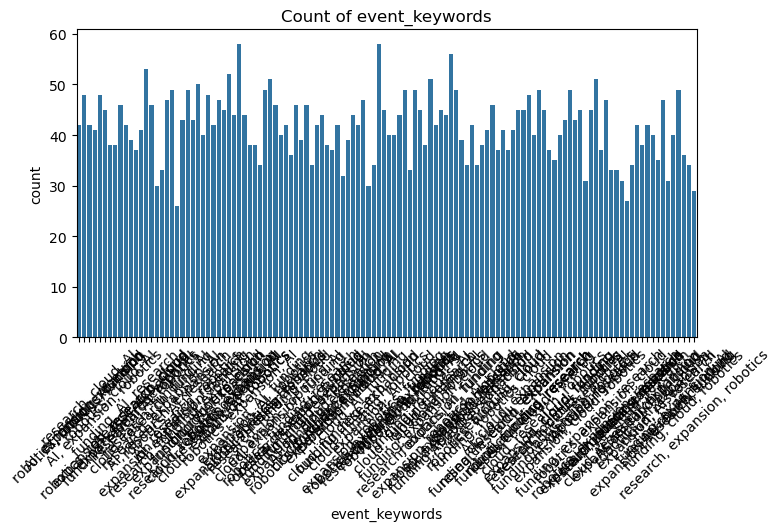


Univariate Analysis for region:
region
Seattle, WA          1029
New York, NY         1028
Mountain View, CA    1018
Austin, TX           1014
London, UK            911
Name: count, dtype: int64


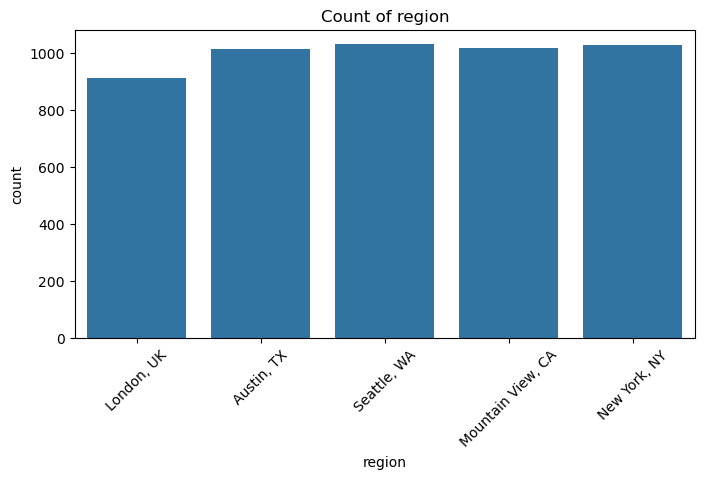

In [9]:
# Categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nUnivariate Analysis for {col}:")
    print(df[col].value_counts())
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.show()


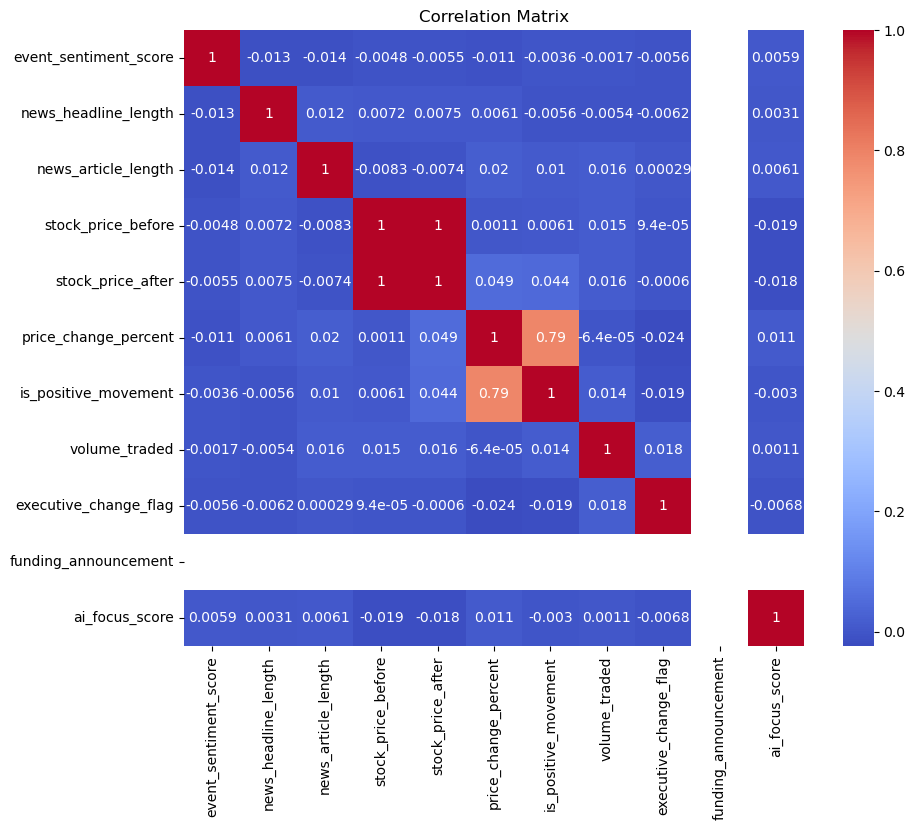

In [10]:
# Bivariate Analysis
# Correlation matrix for numerical data
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

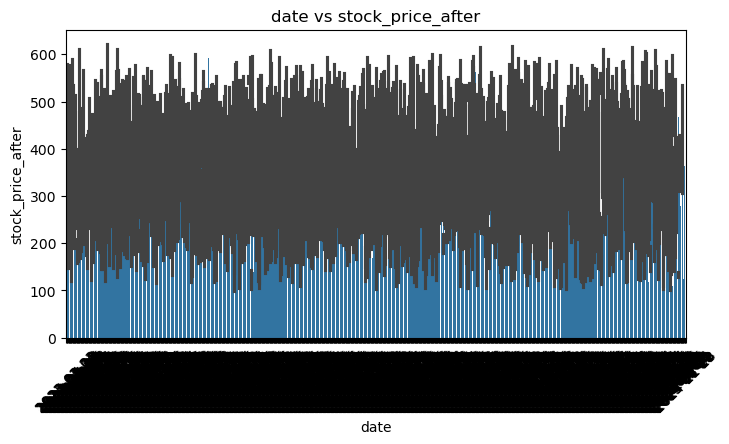

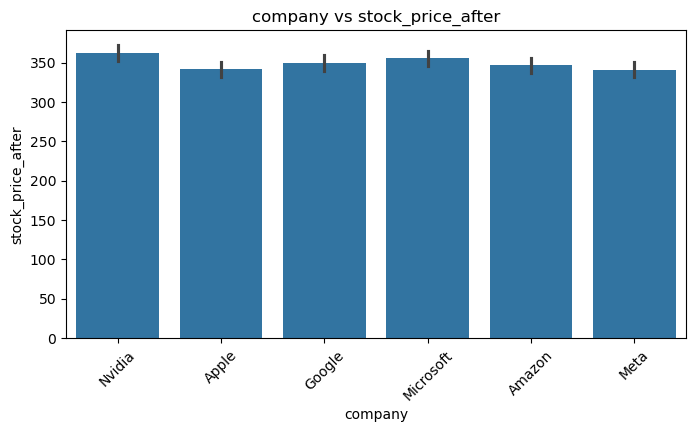

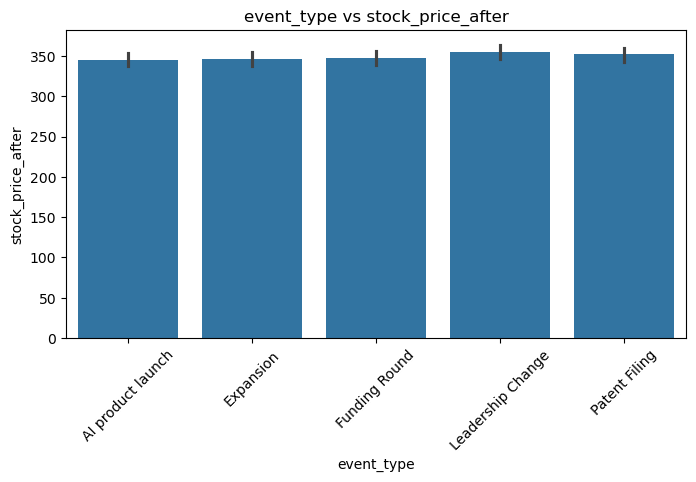

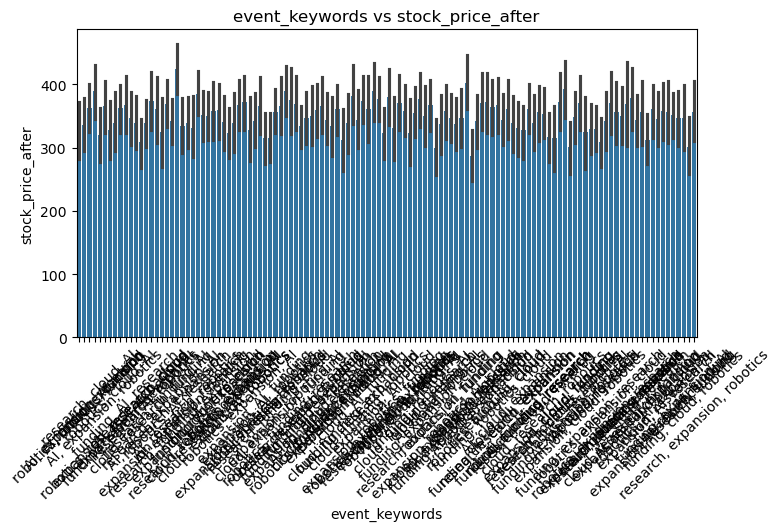

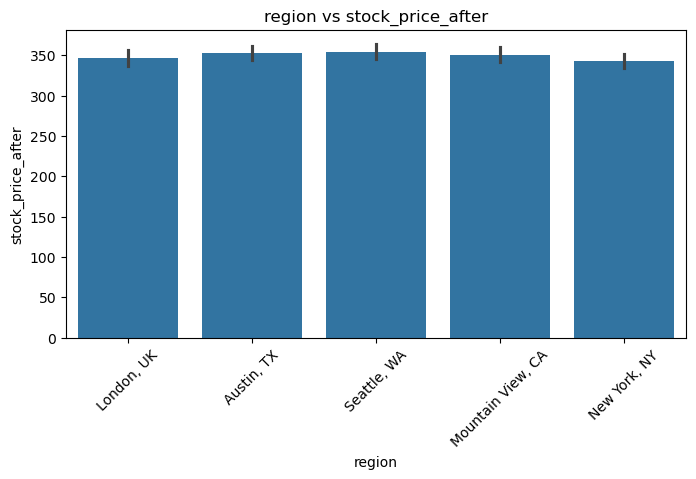

In [13]:
# Categorical-Numerical (Bar plot with stock_price_after)
for cat_col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=cat_col, y='stock_price_after', data=df)
    plt.title(f"{cat_col} vs stock_price_after")
    plt.xticks(rotation=45)
    plt.show()

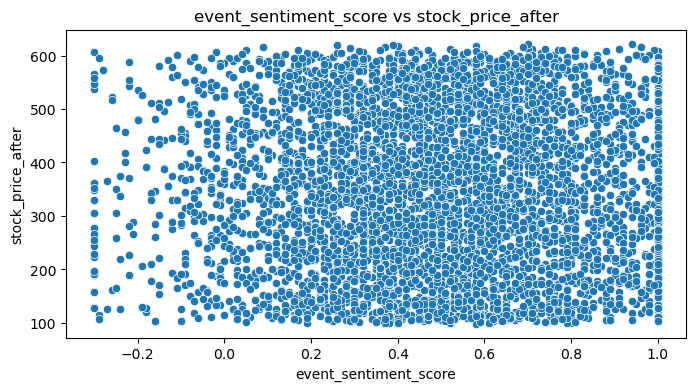

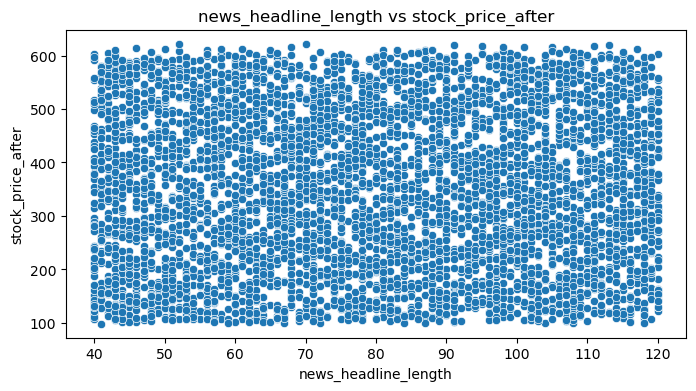

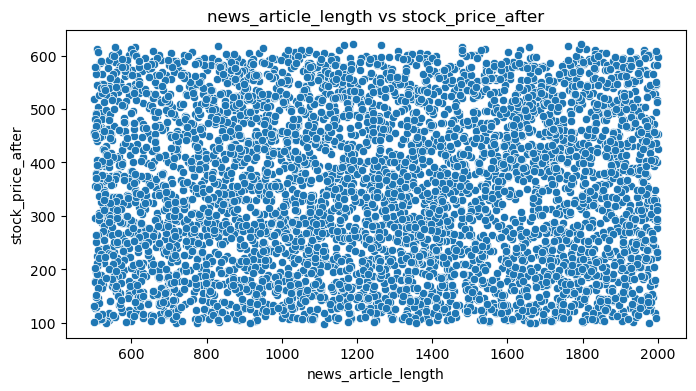

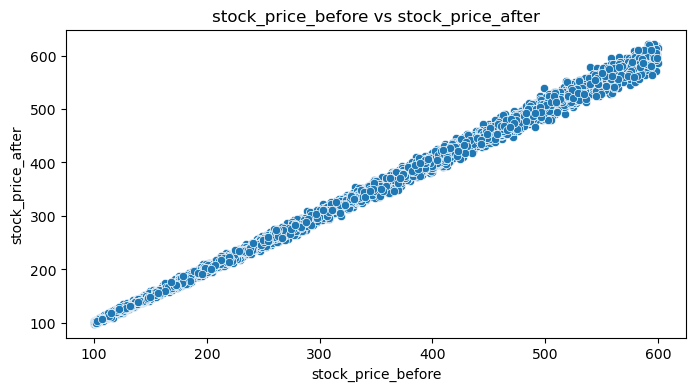

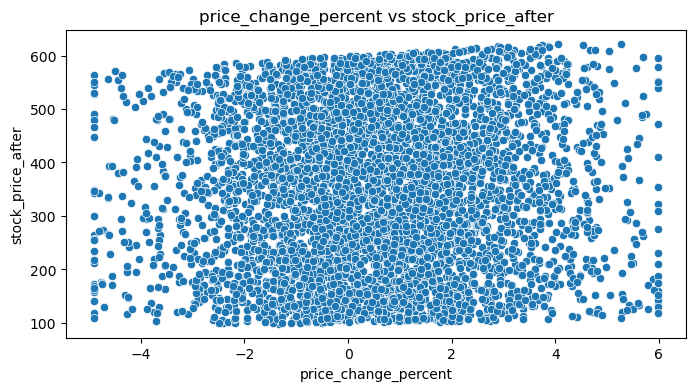

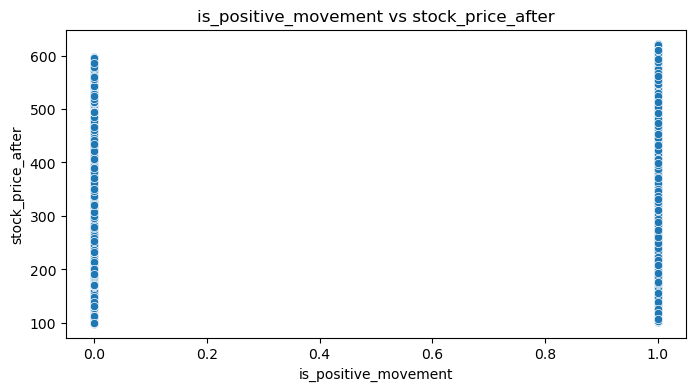

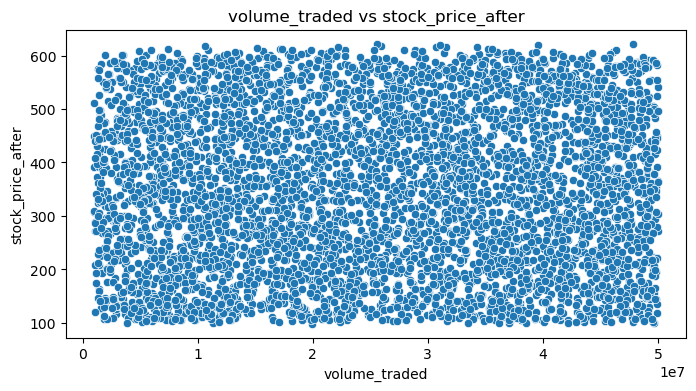

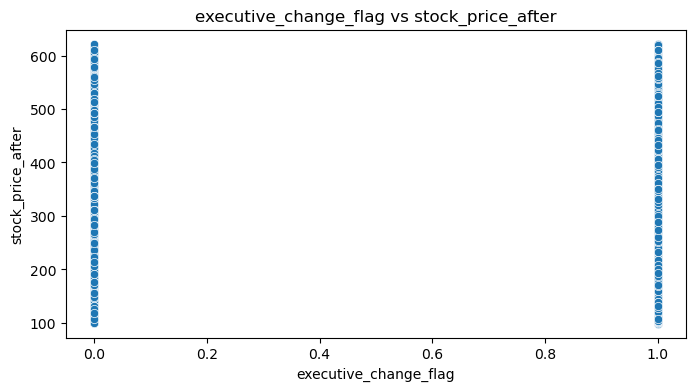

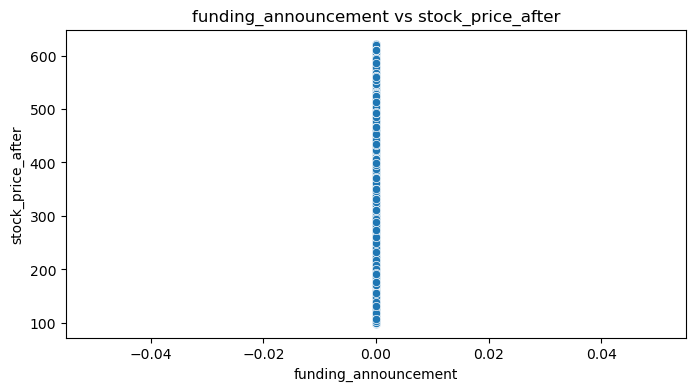

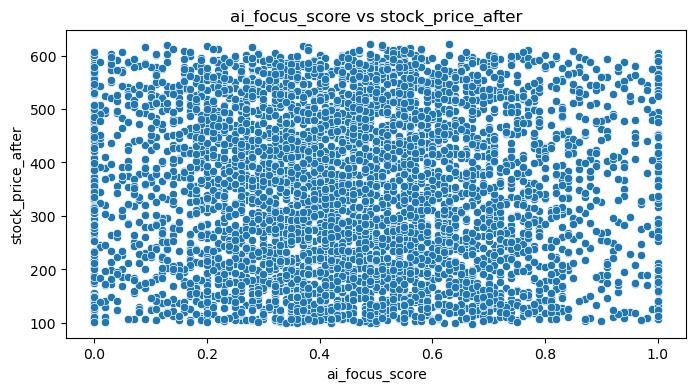

In [12]:
# Numerical-Numerical (Scatter plot with stock_price_after)
for col in numerical_cols:
    if col != 'stock_price_after':
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=col, y='stock_price_after', data=df)
        plt.title(f"{col} vs stock_price_after")
        plt.show()

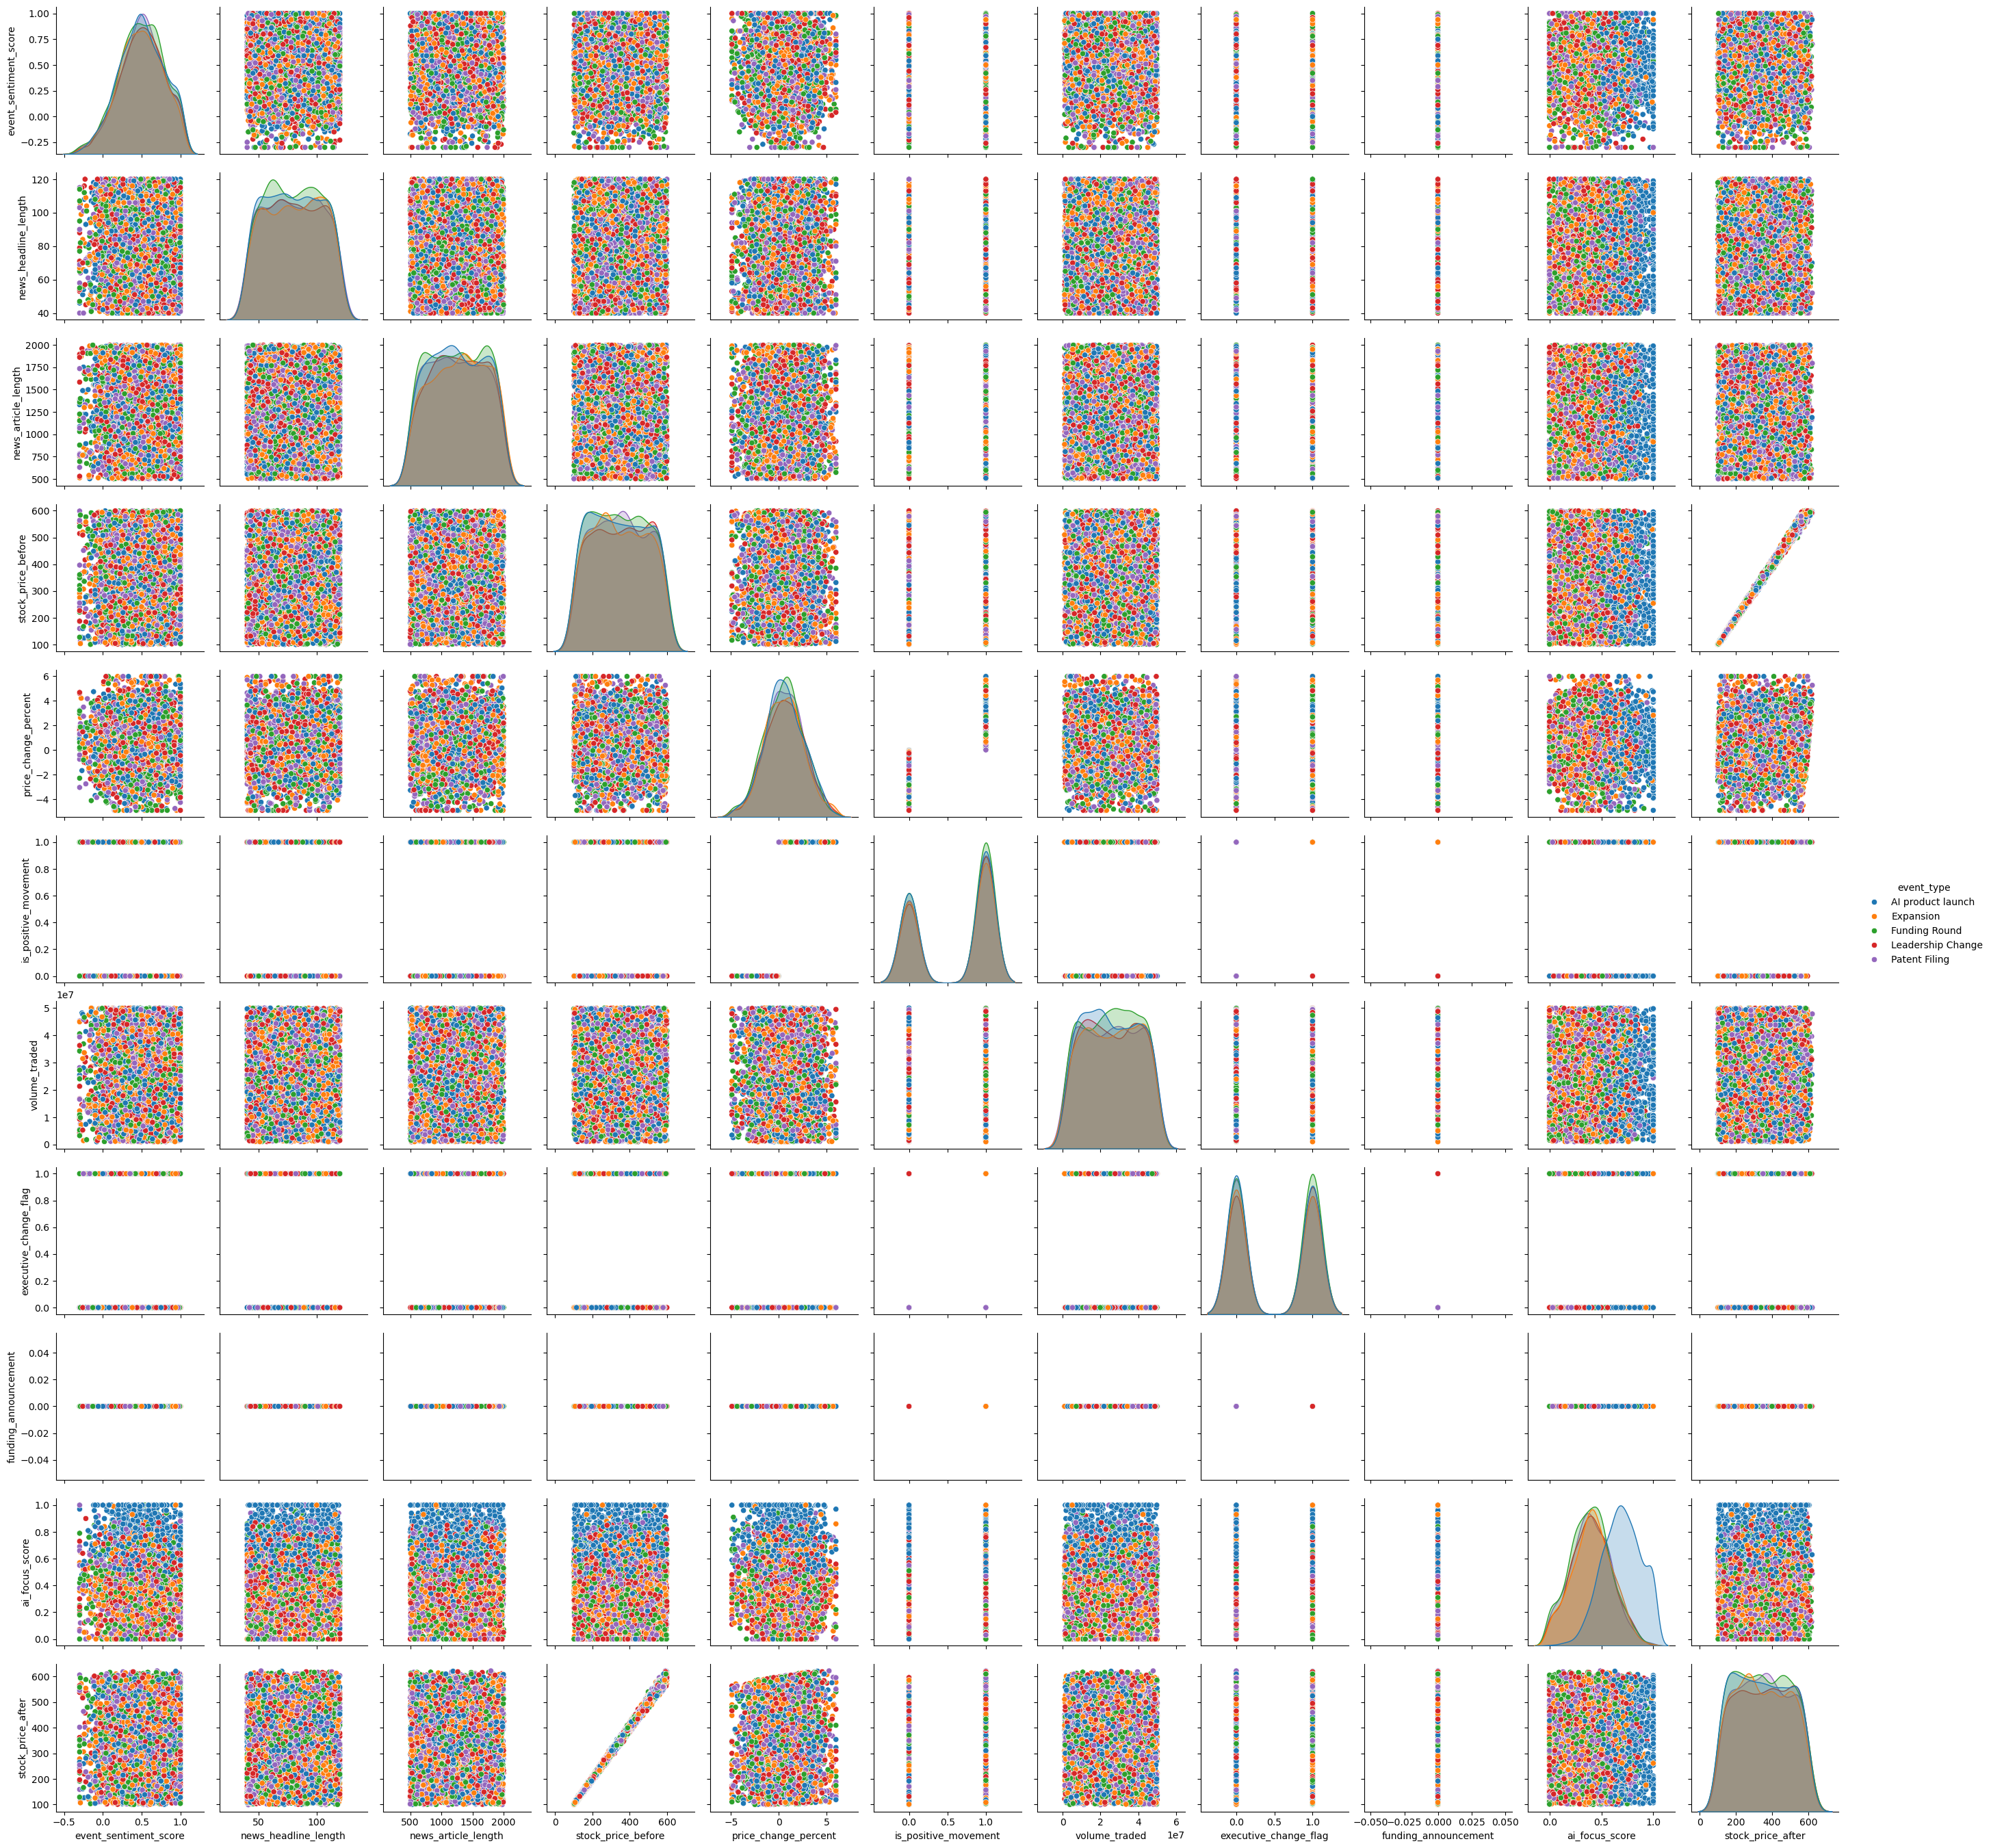

In [17]:
# Multivariate Analysis
# Pair plot for numerical columns with categorical hue
sns.pairplot(df, hue='event_type', vars=[col for col in numerical_cols if col != 'stock_price_after'] + ['stock_price_after'])
plt.show()


Pivot Table (Event Type vs Region vs Stock Price After):
region             Austin, TX  London, UK  Mountain View, CA  New York, NY  \
event_type                                                                   
AI product launch  360.667551  339.125833         358.152293    318.849565   
Expansion          339.236244  347.752848         340.249598    359.895635   
Funding Round      352.710603  341.901353         349.576396    330.618559   
Leadership Change  357.168538  356.364722         353.345414    347.716599   
Patent Filing      354.049109  349.706543         351.445261    360.556667   

region             Seattle, WA  
event_type                      
AI product launch   351.887658  
Expansion           345.843282  
Funding Round       364.334466  
Leadership Change   363.622629  
Patent Filing       345.393585  


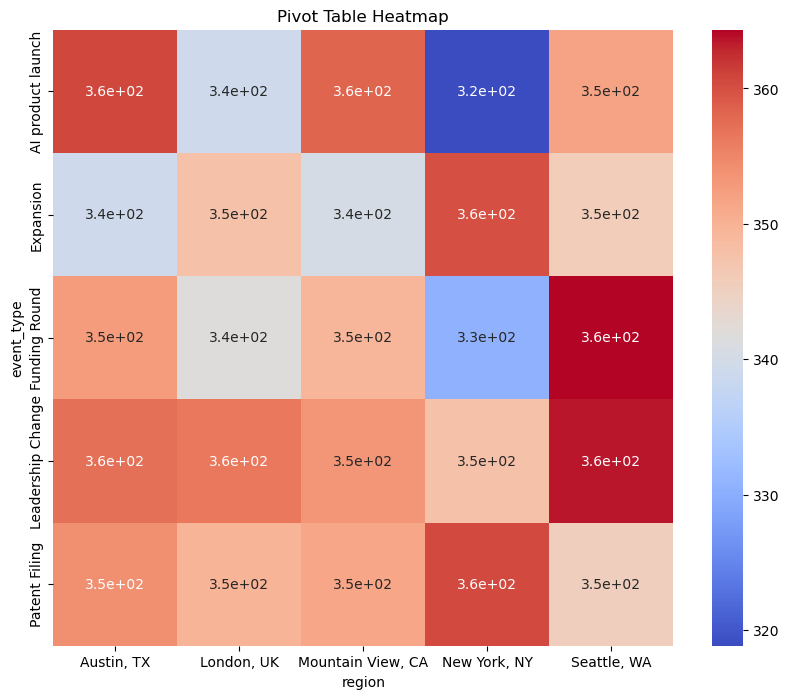

In [18]:
# Categorical-Categorical-Numerical (Pivot table)
pivot = pd.pivot_table(df, values='stock_price_after', index='event_type', columns='region', aggfunc='mean')
print("\nPivot Table (Event Type vs Region vs Stock Price After):")
print(pivot)
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title("Pivot Table Heatmap")
plt.show()

# Make Data Ready for ML

In [20]:
# Separate dependent and independent variables
X = df.drop(columns=['stock_price_after'])  # Independent variables
y = df['stock_price_after']  # Dependent variable

# Encoding categorical variables
le = LabelEncoder()
for col in categorical_cols:
    if col in X.columns:
        X[col] = le.fit_transform(X[col].astype(str))

In [21]:
# Scaling numerical variables
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [22]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Remove 'date' column if it exists as it's not relevant for ML
if 'date' in X.columns:
    X = X.drop(columns=['date'])
    X_train = X_train.drop(columns=['date'])
    X_test = X_test.drop(columns=['date'])

# Find the Base Model

In [25]:
# Using RandomForestRegressor as a base model for regression
base_model = RandomForestRegressor(random_state=42)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

In [26]:
# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"\nBase Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")



Base Model Performance:
RMSE: 1.64
R2 Score: 1.00


#  Hyperparameter Tuning using Cross-Validation

In [27]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)
print(f"Best Model Performance:")
print(f"RMSE: {rmse_best:.2f}")
print(f"R2 Score: {r2_best:.2f}")


Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Model Performance:
RMSE: 1.64
R2 Score: 1.00


# Feature Selection using RFE


In [31]:
rfe = RFE(estimator=best_model, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_].tolist()
print("\nSelected Features:", selected_features)



Selected Features: ['company', 'event_sentiment_score', 'event_keywords', 'news_headline_length', 'news_article_length', 'stock_price_before', 'price_change_percent', 'is_positive_movement', 'volume_traded', 'ai_focus_score']


# Train model with selected features

In [32]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
best_model.fit(X_train_selected, y_train)
y_pred_selected = best_model.predict(X_test_selected)
rmse_selected = np.sqrt(mean_squared_error(y_test, y_pred_selected))
r2_selected = r2_score(y_test, y_pred_selected)
print(f"\nModel Performance with Selected Features:")
print(f"RMSE: {rmse_selected:.2f}")
print(f"R2 Score: {r2_selected:.2f}")


Model Performance with Selected Features:
RMSE: 1.60
R2 Score: 1.00
